<a href="https://colab.research.google.com/github/MartinPdeS/FlowCyPy/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install FlowCyPy==0.27.2 --no-cache-dir --quiet
!pip install numpy==2.3.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 54.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymiesim 3.5.4.3 requires numpy==2.2.6, but you have numpy 2.3.1 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.1 which is incompatible.


In [1]:
import FlowCyPy
print(FlowCyPy.__version__)

0.27.2


In [2]:
import numpy as np
from FlowCyPy import units

In [3]:
from FlowCyPy import SimulationSettings

SimulationSettings.include_noises = True
SimulationSettings.include_shot_noise = True
SimulationSettings.include_dark_current_noise = True
SimulationSettings.include_source_noise = True
SimulationSettings.include_amplifier_noise = True
SimulationSettings.assume_perfect_hydrodynamic_focusing = True
np.random.seed(3)

Fluidics
--------

In [4]:
from FlowCyPy.fluidics import Fluidics, ScattererCollection, FlowCell, distribution, population

flow_cell = FlowCell(
    sample_volume_flow=80 * units.microliter / units.minute,
    sheath_volume_flow=1 * units.milliliter / units.minute,
    width=200 * units.micrometer,
    height=100 * units.micrometer,
)

scatterer_collection = ScattererCollection(medium_refractive_index=1.33 * units.RIU)

scatterer_collection.add_population(population.Sphere(
    name='Pop 0',
    particle_count=5e9 * units.particle / units.milliliter,
    diameter=distribution.RosinRammler(150 * units.nanometer, spread=30),
    refractive_index=distribution.Normal(1.44 * units.RIU, std_dev=0.002 * units.RIU)
))

scatterer_collection.add_population(population.Sphere(
    name='Pop 1',
    particle_count=5e9 * units.particle / units.milliliter,
    diameter=distribution.RosinRammler(200 * units.nanometer, spread=30),
    refractive_index=distribution.Normal(1.44 * units.RIU, std_dev=0.002 * units.RIU)
))

scatterer_collection.dilute(factor=80)

fluidics = Fluidics(
    scatterer_collection=scatterer_collection,
    flow_cell=flow_cell
)

Opto-Electronics
----------------

In [5]:
from FlowCyPy.opto_electronics import OptoElectronics, Detector, TransimpedanceAmplifier, source

source = source.GaussianBeam(
    numerical_aperture=0.1 * units.AU,
    wavelength=450 * units.nanometer,
    optical_power=200 * units.milliwatt,
    RIN=-140
)


detectors = [
    Detector(name='forward', phi_angle=0 * units.degree,  numerical_aperture=0.3 * units.AU, responsivity=1 * units.ampere / units.watt),
    Detector(name='side',    phi_angle=90 * units.degree, numerical_aperture=0.3 * units.AU, responsivity=1 * units.ampere / units.watt),
    Detector(name='det 2',   phi_angle=30 * units.degree, numerical_aperture=0.3 * units.AU, responsivity=1 * units.ampere / units.watt),
]

amplifier = TransimpedanceAmplifier(
    gain=10 * units.volt / units.ampere,
    bandwidth=10 * units.megahertz,
    voltage_noise_density=0.1 * units.nanovolt / units.sqrt_hertz,
    current_noise_density=0.2 * units.femtoampere / units.sqrt_hertz
)

opto_electronics = OptoElectronics(
    detectors=detectors,
    source=source,
    amplifier=amplifier
)

Signal Processing
-----------------

In [6]:
from FlowCyPy.signal_processing import SignalProcessing, triggering_system, Digitizer, circuits, peak_locator

analog_processing = [
    circuits.BaselineRestorator(window_size=10 * units.microsecond),
    circuits.BesselLowPass(cutoff=2 * units.megahertz, order=4, gain=2)
]

digitizer = Digitizer(
    bit_depth='14bit',
    saturation_levels='auto',
    sampling_rate=60 * units.megahertz
)

_triggering_system = triggering_system.DynamicWindow(
    trigger_detector_name='forward',
    threshold=10 * units.microvolt,
    pre_buffer=20,
    post_buffer=20,
    max_triggers=-1
)

peak_algorithm = peak_locator.GlobalPeakLocator(compute_width=False)

signal_processing = SignalProcessing(
    digitizer=digitizer,
    analog_processing=analog_processing,
    triggering_system=_triggering_system,
    peak_algorithm=peak_algorithm
)

Flow Cytometer
--------------

In [14]:
from FlowCyPy import FlowCytometer

cytometer = FlowCytometer(
    opto_electronics=opto_electronics,
    fluidics=fluidics,
    signal_processing=signal_processing,
    background_power=0.001 * units.milliwatt
)

results = cytometer.run(run_time=2 * units.millisecond)

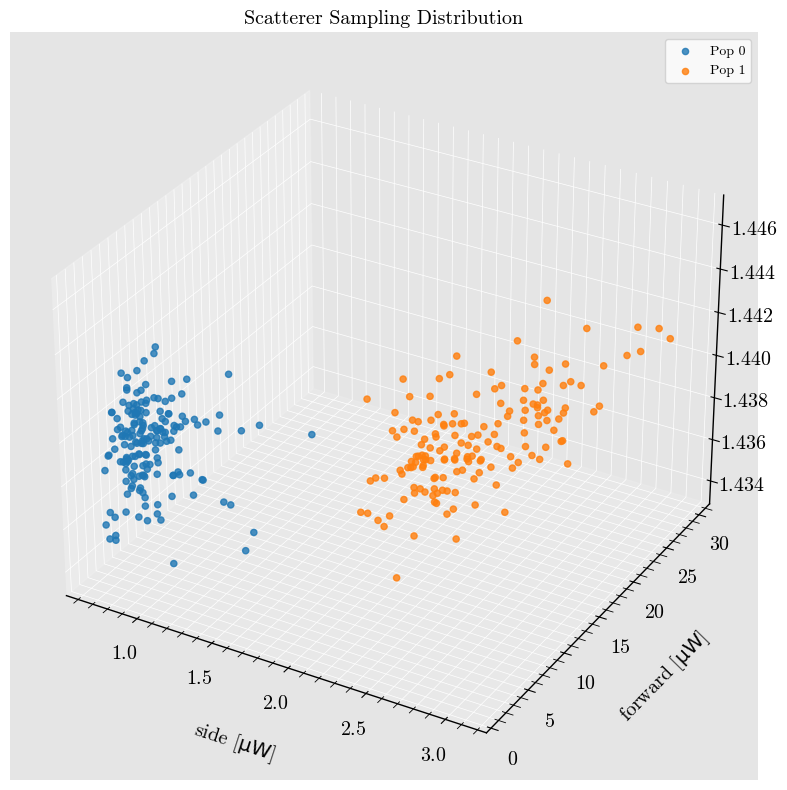

In [15]:
_ = results.events.plot(x='side', y='forward', z='RefractiveIndex')

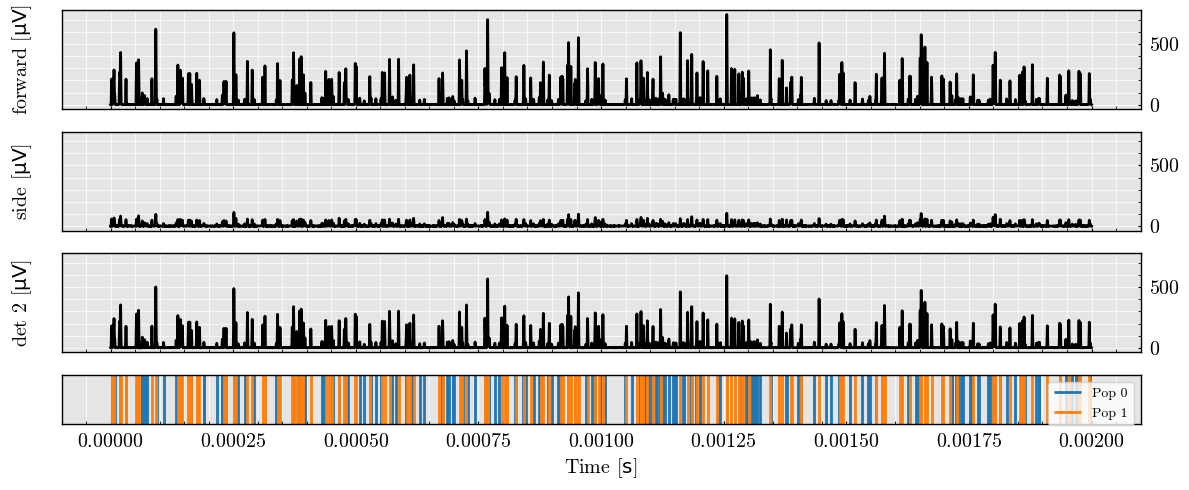

In [16]:
results.analog.normalize_units(signal_units='max')

_ = results.analog.plot()

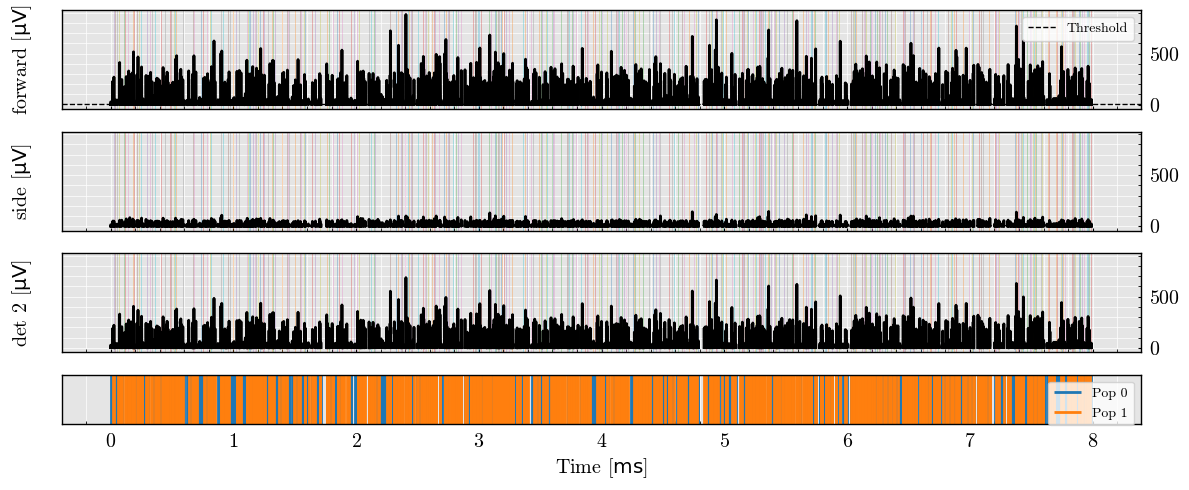

In [13]:
_ = results.triggered_analog.plot()

Classifier
----------

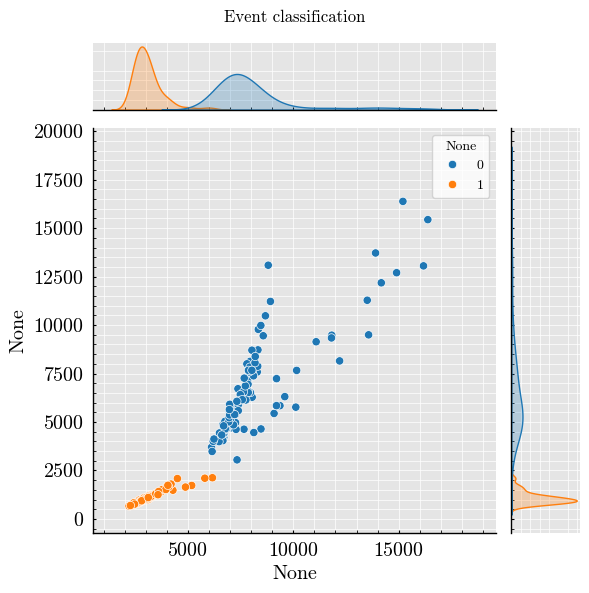

In [17]:
from FlowCyPy.classifier import KmeansClassifier

classifier = KmeansClassifier(number_of_cluster=2)

classified_df = classifier.run(
    dataframe=results.peaks.unstack('Detector'),
    features=['Height'],
    detectors=['side', 'forward']
)

_ = classified_df.plot(
    x=('side', 'Height'),
    y=('forward', 'Height')
)